In [1]:
%matplotlib inline


# Station Plot

This notebook is adapted from https://unidata.github.io/MetPy/latest/examples/plots/Station_Plot.html

Make a station plot, complete with sky cover and weather symbols.

The station plot itself is pretty straightforward, but there is a bit of code to perform the
data-wrangling (hopefully that situation will improve in the future). Certainly, if you have
existing point data in a format you can work with trivially, the station plot will be simple.


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from metpy.calc import reduce_point_density
from metpy.cbook import get_test_data
from metpy.io import metar
from metpy.plots import add_metpy_logo, current_weather, sky_cover, StationPlot

In [3]:
# Get real-time metar data
# Author: Yongjie Huang
# Date: 2022-02-24
from os.path import exists
from urllib.request import urlretrieve

def get_real_time_metar_data(fname):
    base_url = 'https://thredds-test.unidata.ucar.edu/thredds/fileServer/noaaport/text/metar/'
    data_dir = '/tmp/'
    path_to_file = data_dir + fname
    
    if exists(path_to_file):
        print(f'File exists: {path_to_file}')
    else:
        print(f"Downloading file '{fname}' from '{base_url+fname}' to '{path_to_file}'.")
        urlretrieve(base_url+fname, path_to_file)

    return path_to_file

## The setup

First download and read in the station data. 

We use the get_real_time_metar_data function defined above to download 'realtime' data from Unidata THREDDS server.
the metar reader because it simplifies a lot of tasks,
like dealing with separating text and assembling a pandas dataframe.

https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.html

In [4]:
# Download metar data in text format.

metar_data = get_real_time_metar_data('metar_20220308_0000.txt')

metar_data

File exists: /tmp/metar_20220308_0000.txt


'/tmp/metar_20220308_0000.txt'

Parse a downloaded text file containing multiple METAR reports and/or text products, by calling metar.parse_metar_file which is part of the metpy.io package. The parser returns the data as pandas dataframe. See
https://unidata.github.io/MetPy/latest/api/generated/metpy.io.parse_metar_file.html

In [5]:
data = metar.parse_metar_file(metar_data)

#data = metar.parse_metar_file(get_test_data('metar_20190701_1200.txt', as_file_obj=False))

data

station_id   latitude  longitude  elevation           date_time  \
station_id                                                                   
KPLD             KPLD  40.450000 -84.983333      282.0 2022-03-07 23:55:00   
KFFA             KFFA  36.020000 -75.670000        4.0 2022-03-07 23:55:00   
KMFV             KMFV  37.630000 -75.770000       15.0 2022-03-07 23:55:00   
K2J9             K2J9  30.600000 -84.550000       69.0 2022-03-07 23:55:00   
KTGI             KTGI  37.833333 -76.000000        2.0 2022-03-07 23:55:00   
...               ...        ...        ...        ...                 ...   
HTMU             HTMU  -1.500000  33.780000     1147.0 2022-03-08 00:00:00   
HTSO             HTSO -10.670000  35.570000     1067.0 2022-03-08 00:00:00   
HTTB             HTTB  -5.070000  32.820000     1190.0 2022-03-08 00:00:00   
HTDA             HTDA  -6.880000  39.200000       55.0 2022-03-08 00:00:00   
HTZA             HTZA  -6.220000  39.220000       15.0 2022-03-08 00:00:00   

            wind_direction  wind_speed  wind_gust  visibility current_wx1  \
station_id                                                                  
KPLD                 290.0        10.0       19.0    16093.44         NaN   
KFFA                 190.0         8.0        NaN    16093.44         NaN   
KMFV                 210.0        10.0       18.0    16093.44         NaN   
K2J9                 200.0         5.0        NaN    16093.44         NaN   
KTGI                 190.0        13.0        NaN    16093.44         NaN   
...                    ...         ...        ...         ...         ...   
HTMU                   0.0         0.0        NaN     9999.00         NaN   
HTSO                 180.0         6.0        NaN     9999.00         NaN   
HTTB                   0.0         0.0        NaN     9999.00         NaN   
HTDA                  20.0         6.0        NaN     9999.00         NaN   
HTZA                   0.0         0.0        NaN     9999.00         NaN   

            ... air_temperature dew_point_temperature altimeter  \
station_id  ...                                                   
KPLD        ...             2.0                  -2.0     30.05   
KFFA        ...            20.0                  14.0     29.88   
KMFV        ...            22.0                  20.0     29.76   
K2J9        ...            23.0                  20.0     30.07   
KTGI        ...            15.0                  11.0     29.75   
...         ...             ...                   ...       ...   
HTMU        ...            23.0                  21.0     29.91   
HTSO        ...            20.0                  19.0     30.00   
HTTB        ...            21.0                  19.0     29.97   
HTDA        ...            22.0                  24.0     29.80   
HTZA        ...            26.0                  23.0     29.77   

            current_wx1_symbol current_wx2_symbol  current_wx3_symbol  \
station_id                                                              
KPLD                         0                  0                   0   
KFFA                         0                  0                   0   
KMFV                         0                  0                   0   
K2J9                         0                  0                   0   
KTGI                         0                  0                   0   
...                        ...                ...                 ...   
HTMU                         0                  0                   0   
HTSO                         0                  0                   0   
HTTB                         0                  0                   0   
HTDA                         0                  0                   0   
HTZA                         0                  0                   0   

                              remarks  air_pressure_at_sea_level  \
station_id                                                         
KPLD                              AO

In [6]:
print( data['station_id'].shape )

(9061,)


In [7]:
# Drop rows with missing winds and sea level pressure
data = data.dropna(how='any', subset=['wind_direction', 'wind_speed','air_pressure_at_sea_level','air_temperature'])
print( data['station_id'].shape )

(8090,)


In [8]:
data

station_id   latitude  longitude  elevation           date_time  \
station_id                                                                   
KPLD             KPLD  40.450000 -84.983333      282.0 2022-03-07 23:55:00   
KFFA             KFFA  36.020000 -75.670000        4.0 2022-03-07 23:55:00   
KMFV             KMFV  37.630000 -75.770000       15.0 2022-03-07 23:55:00   
K2J9             K2J9  30.600000 -84.550000       69.0 2022-03-07 23:55:00   
KTGI             KTGI  37.833333 -76.000000        2.0 2022-03-07 23:55:00   
...               ...        ...        ...        ...                 ...   
HTMU             HTMU  -1.500000  33.780000     1147.0 2022-03-08 00:00:00   
HTSO             HTSO -10.670000  35.570000     1067.0 2022-03-08 00:00:00   
HTTB             HTTB  -5.070000  32.820000     1190.0 2022-03-08 00:00:00   
HTDA             HTDA  -6.880000  39.200000       55.0 2022-03-08 00:00:00   
HTZA             HTZA  -6.220000  39.220000       15.0 2022-03-08 00:00:00   

            wind_direction  wind_speed  wind_gust  visibility current_wx1  \
station_id                                                                  
KPLD                 290.0        10.0       19.0    16093.44         NaN   
KFFA                 190.0         8.0        NaN    16093.44         NaN   
KMFV                 210.0        10.0       18.0    16093.44         NaN   
K2J9                 200.0         5.0        NaN    16093.44         NaN   
KTGI                 190.0        13.0        NaN    16093.44         NaN   
...                    ...         ...        ...         ...         ...   
HTMU                   0.0         0.0        NaN     9999.00         NaN   
HTSO                 180.0         6.0        NaN     9999.00         NaN   
HTTB                   0.0         0.0        NaN     9999.00         NaN   
HTDA                  20.0         6.0        NaN     9999.00         NaN   
HTZA                   0.0         0.0        NaN     9999.00         NaN   

            ... air_temperature dew_point_temperature altimeter  \
station_id  ...                                                   
KPLD        ...             2.0                  -2.0     30.05   
KFFA        ...            20.0                  14.0     29.88   
KMFV        ...            22.0                  20.0     29.76   
K2J9        ...            23.0                  20.0     30.07   
KTGI        ...            15.0                  11.0     29.75   
...         ...             ...                   ...       ...   
HTMU        ...            23.0                  21.0     29.91   
HTSO        ...            20.0                  19.0     30.00   
HTTB        ...            21.0                  19.0     29.97   
HTDA        ...            22.0                  24.0     29.80   
HTZA        ...            26.0                  23.0     29.77   

            current_wx1_symbol current_wx2_symbol  current_wx3_symbol  \
station_id                                                              
KPLD                         0                  0                   0   
KFFA                         0                  0                   0   
KMFV                         0                  0                   0   
K2J9                         0                  0                   0   
KTGI                         0                  0                   0   
...                        ...                ...                 ...   
HTMU                         0                  0                   0   
HTSO                         0                  0                   0   
HTTB                         0                  0                   0   
HTDA                         0                  0                   0   
HTZA                         0                  0                   0   

                              remarks  air_pressure_at_sea_level  \
station_id                                                         
KPLD                              AO

In [9]:
# option to plot US or China region


plot_region = 'China'
plot_region = 'US'

# Set up the map projection

if plot_region == 'US':
  proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                               standard_parallels=[35])
else:
  proj = ccrs.LambertConformal(central_longitude=95, central_latitude=35,
                               standard_parallels=[35])

# Use the Cartopy map projection to transform station locations in lat/lon to the map coordinates
point_locs = proj.transform_points(ccrs.PlateCarree(), data['longitude'].values,
                                   data['latitude'].values)

point_locs
print( point_locs.shape, data['station_id'].values.shape )

nstations = data['station_id'].values.size
print( nstations )

nstations
data['longitude'][1]

(8090, 3) (8090,)
8090


-75.67

Screen observations and keep only those within the lat/lon bounds. Put kept observations and their (x,y) and (lat,lon) locations in new arrays. Rememeber how many observations are kept (n_stations).

In [10]:
xstation = np.zeros( nstations )
ystation = np.zeros( nstations )
lat_keep = np.zeros( nstations )
lon_keep = np.zeros( nstations )
pmsl_keep = np.zeros( nstations )

lonmin = -140
lonmax = -50
latmin = 15
latmax = 70
kk = 0
print( nstations )

'''
for k in range(0, nstations ):
...
        if np.isnan( pmsl_keep[kk]):  # check if pmsl is NaN/nan. If so, skip that station (don't count into kk)
            print( k, pmsl_keep[kk] )
        else:
            kk += 1
n_stations = kk + 1  # The total number of station kept should be the final count kk plus 1 (kk starts from 0)

'''

8090


"\nfor k in range(0, nstations ):\n...\n        if np.isnan( pmsl_keep[kk]):  # check if pmsl is NaN/nan. If so, skip that station (don't count into kk)\n            print( k, pmsl_keep[kk] )\n        else:\n            kk += 1\nn_stations = kk + 1  # The total number of station kept should be the final count kk plus 1 (kk starts from 0)\n\n"

In [11]:
'''
print(n_stations, np.min(xstation[0:n_stations]), np.max(xstation[0:n_stations]), 
      np.min(ystation[0:n_stations]), np.max(ystation[0:n_stations]) )
'''

'\nprint(n_stations, np.min(xstation[0:n_stations]), np.max(xstation[0:n_stations]), \n      np.min(ystation[0:n_stations]), np.max(ystation[0:n_stations]) )\n'

In [12]:
# Define  (x, y) coordinates of the objective analysis grid in the map projection space based on the 
# max/min x and y values found above.
#
'''
xgrid = np.array( range(  xwest,  xeast, xstep ))
ygrid = np.array( range( ysouth, ynorth, ystep ))
nxgrid = xgrid.size
nygrid = ygrid.size

print( nxgrid, nygrid )

'''

'\nxgrid = np.array( range(  xwest,  xeast, xstep ))\nygrid = np.array( range( ysouth, ynorth, ystep ))\nnxgrid = xgrid.size\nnygrid = ygrid.size\n\nprint( nxgrid, nygrid )\n\n'

Perform Cressman objective analysis for mean sea level pressure and store results in zgrid.

In [13]:
'''
R2 = 500000**2

# enter Cressman objective analysis code here. Put analysis in zgrid.

print(np.min(zgrid), np.max(zgrid))
'''

'\nR2 = 500000**2\n\n# enter Cressman objective analysis code here. Put analysis in zgrid.\n\nprint(np.min(zgrid), np.max(zgrid))\n'

This sample data has *way* too many stations to plot all of them. The number
of stations plotted will be reduced using `reduce_point_density`.

In [14]:
#  Reduce the number of stations to be plotted by setting a 300km radius

data = data[reduce_point_density(point_locs, 250000.)]
point_locs
print( point_locs.shape )

(8090, 3)


## The payoff



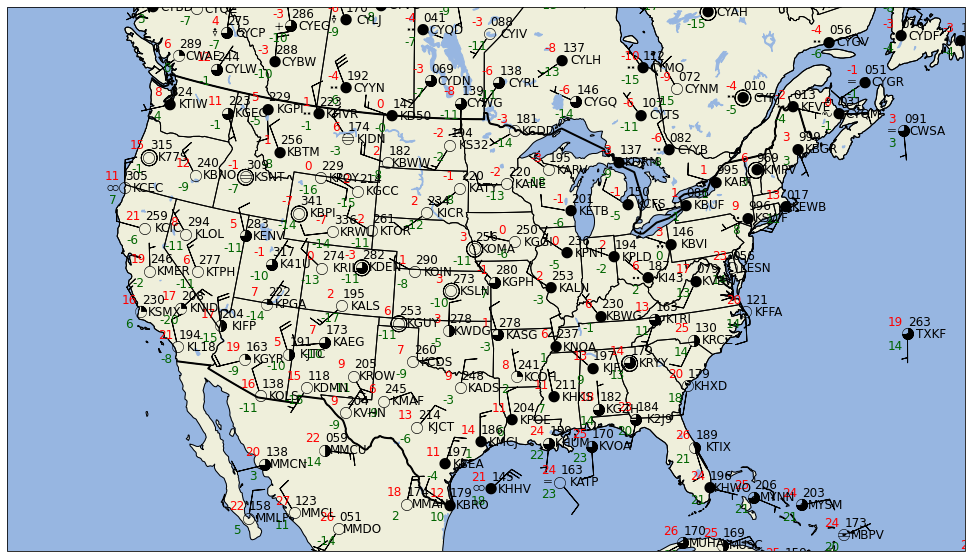

In [15]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 600

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Set plot bounds

if plot_region == 'US':
  ax.set_extent((-125, -65, 20, 52))
else:
  ax.set_extent((75, 125, 15, 50))

#
# plot objectively analyzed mean sea level pressure field.
#
'''
x2d, y2d = np.meshgrid( xgrid, ygrid )
ctr = ax.contour( ...  )
ax.clabel( ....  )
'''

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'].values, data['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', data['air_temperature'].values, color='red')
stationplot.plot_parameter('SW', data['dew_point_temperature'].values,color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', data['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', data['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', data['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(data['eastward_wind'].values, data['northward_wind'].values)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
stationplot.plot_text((2, 0), data['station_id'].values)

plt.show()